In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.feature_selection import mutual_info_classif

#import lazypredict
#from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split#,cross_val_score
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor # < DO NOT UNCOMMENT ON A LOCAL MASHINE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor#, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 


In [ ]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 27 kB/s 


## READ DATA

In [ ]:
# local only:
# df_test = pd.read_csv('test.csv')
# df_train = pd.read_csv('train.csv')
# df_sub = pd.read_csv('sample_submission.csv')


In [ ]:
#local:
path = "ML/"

# remote:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/module_6/ML/"


# data =pd.read_csv(path + 'data_ML.csv')
# data = pd.read_csv('data_dum.csv')
data = df_train = pd.read_csv(path + 'data_noouts.csv')
# data = pd.read_csv(path + 'data_noouts_dum.csv')



Mounted at /content/drive


In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69815 entries, 0 to 69814
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         69815 non-null  int64  
 1   model_name    69815 non-null  int64  
 2   body_type     69815 non-null  int64  
 3   doors         69815 non-null  int64  
 4   color         69815 non-null  int64  
 5   engine_V      69815 non-null  float64
 6   power         69815 non-null  float64
 7   fuel          69815 non-null  int64  
 8   mileage       69815 non-null  float64
 9   transmission  69815 non-null  int64  
 10  owners        69815 non-null  int64  
 11  pass          69815 non-null  int64  
 12  drive         69815 non-null  int64  
 13  wheel         69815 non-null  int64  
 14  price         69815 non-null  int64  
 15  test_train    69815 non-null  object 
 16  model_age     69815 non-null  float64
 17  new_model     69815 non-null  int64  
 18  car_age       69815 non-nu

In [ ]:
data.isna().sum()


brand           0
model_name      0
body_type       0
doors           0
color           0
engine_V        0
power           0
fuel            0
mileage         0
transmission    0
owners          0
pass            0
drive           0
wheel           0
price           0
test_train      0
model_age       0
new_model       0
car_age         0
new_car         0
retro           0
raritet         0
electrocar      0
petrol_car      0
1_owner         0
dtype: int64

In [ ]:
data[data["price"]==0]


,brand,model_name,body_type,doors,color,engine_V,power,fuel,mileage,transmission,owners,pass,drive,wheel,price,test_train,model_age,new_model,car_age,new_car,retro,raritet,electrocar,petrol_car,1_owner
35129,8,299,9,4,2,0.788457,4.663439,4,11.211834,0,2,1,1,0,0,test,2.079442,0,2.079442,0,0,0,0,1,0
35130,8,299,9,4,1,0.955511,4.709530,4,11.011456,3,0,1,1,0,0,test,1.386294,0,1.386294,0,0,0,0,1,1
35131,8,332,9,4,6,1.029619,5.030438,4,11.385103,0,0,1,1,0,0,test,2.079442,0,2.079442,0,0,0,0,1,1
35132,8,299,9,4,3,0.955511,4.709530,4,11.461643,1,0,1,1,0,0,test,2.079442,0,2.079442,0,0,0,0,1,1
35133,8,299,9,4,14,1.029619,5.030438,4,10.977414,1,0,1,1,0,0,test,2.564949,0,2.564949,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69810,1,449,0,4,6,1.386294,5.521461,0,2.302585,1,0,1,0,0,0,test,0.693147,0,0.693147,0,0,0,0,0,1
69811,1,451,0,4,14,1.386294,5.521461,0,2.772589,1,0,1,0,0,0,test,1.098612,0,1.098612,0,0,0,0,0,1
69812,1,2,19,3,14,1.098612,5.252273,0,2.772589,1,0,1,0,0,0,test,1.098612,0,1.098612,0,0,0,0,0,1
69813,1,458,20,1,3,1.098612,3.850148,4,2.397895,3,2,1,2,0,0,test,4.430817,0,4.430817,0,1,1,0,1,0


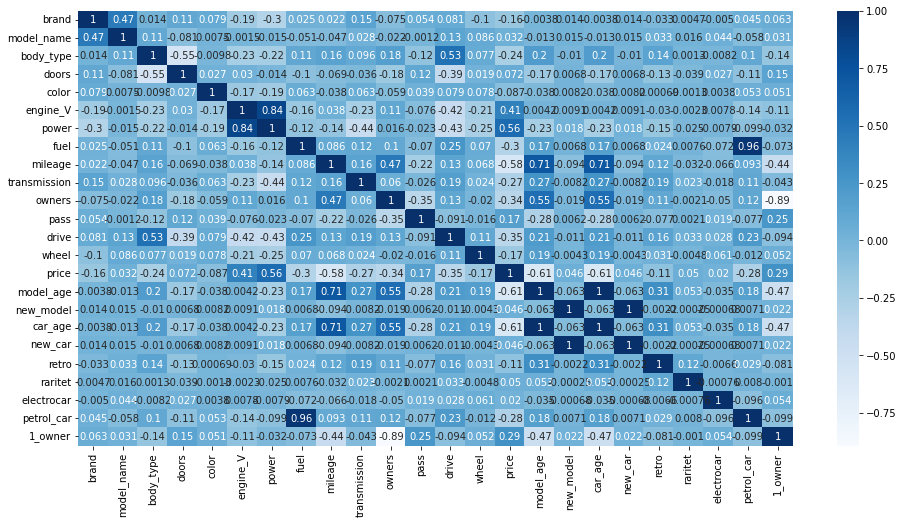

In [ ]:
# heatmap 
plt.figure(figsize=(16,8))
sns.heatmap(data[data.test_train=="train"].corr(),annot=True, cmap="Blues")


#### Несколько выводов:
    Привод и количество дверей как-то зависят от типа кузова
    Цена сильно зависит (обратно) от пробега и возраста
    Пробег и возраст скореллированы
    Высокая корреляция присутствует между (model_age и car_age) и между (new_car и new_model) и (fuel и petrol_car) признаками 
Посмотрим на значимость признаков, уберем model_age и new_model





In [ ]:
used_features = list(data.columns)
used_features.remove("test_train")
used_features.remove("price")
used_features


['brand',
 'model_name',
 'body_type',
 'doors',
 'color',
 'engine_V',
 'power',
 'fuel',
 'mileage',
 'transmission',
 'owners',
 'pass',
 'drive',
 'wheel',
 'model_age',
 'new_model',
 'car_age',
 'new_car',
 'retro',
 'raritet',
 'electrocar',
 'petrol_car',
 '1_owner']

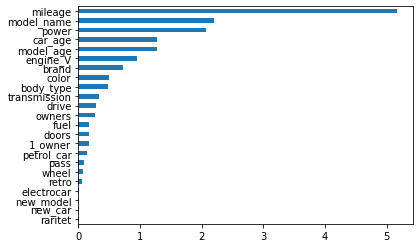

In [ ]:
# посмотрим на значимость признаков:
imp_cat = pd.Series(mutual_info_classif(data[data['price']>0][used_features],
                                     data[data['price']>0]['price'],
                                     discrete_features = True), index=used_features)
#plt.figure(figsize=(15,15))
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')


 Самый важный признак - пробег, а также мощность, имя модели, возраст, объем двигателя, марка и цвет
 
 удалим  скореллированные признаки, так как на цену они влияют одинаково в данном датасете

In [ ]:
data.drop(["model_age", 
           "new_model", 
           "petrol_car"#, 
          # "model_name"
          ], axis=1, inplace=True)


In [ ]:
used_features.remove("model_age")
used_features.remove("petrol_car")
used_features.remove("new_model")
#used_features.remove("model_name")


## ML

разделяем датасеты

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69815 entries, 0 to 69814
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         69815 non-null  int64  
 1   model_name    69815 non-null  int64  
 2   body_type     69815 non-null  int64  
 3   doors         69815 non-null  int64  
 4   color         69815 non-null  int64  
 5   engine_V      69815 non-null  float64
 6   power         69815 non-null  float64
 7   fuel          69815 non-null  int64  
 8   mileage       69815 non-null  float64
 9   transmission  69815 non-null  int64  
 10  owners        69815 non-null  int64  
 11  pass          69815 non-null  int64  
 12  drive         69815 non-null  int64  
 13  wheel         69815 non-null  int64  
 14  price         69815 non-null  int64  
 15  test_train    69815 non-null  object 
 16  car_age       69815 non-null  float64
 17  new_car       69815 non-null  int64  
 18  retro         69815 non-nu

In [ ]:
df_train = data[data.test_train == "train"].drop("test_train", axis=1)
df_test = data[data.test_train == "test"].drop(['price', 'test_train'], axis=1)
len(df_test)

34686

Назначаем целевую переменную и производим разбивку train данных

In [ ]:
y = df_train["price"]
X = df_train.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


Построим модели и посчитаем предсказания, где возможно локально, где нет - на colab

## 1. Наивная модель

In [ ]:
y = df_train["price"]
X = df_train.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train


In [ ]:
# Находим median по экземплярам enginepower в трейне и размечаем тест
predict = X_test['power'].map(
    tmp_train.groupby('power')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")


Точность наивной модели по метрике MAPE: 62.50%


### result:   
    data_ML: 66.57%
    data_noouts: 62.50%
    
    

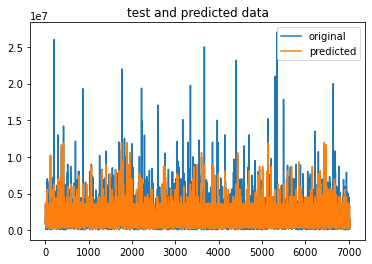

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, predict, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()

## 2. CatBoost

Столкнулась с неразрешимой проблемой на всех имеющихся во владении компьютерах

https://stackoverflow.com/questions/47022997/jupyter-the-kernel-appears-to-have-died-it-will-restart-automatically
    
на colab получился результат 

In [ ]:
y = df_train["price"].values
X = df_train.drop("price", axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
CBR = CatBoostRegressor(iterations=5000,
                          random_seed=42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
CBR.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=0,
          use_best_model=True,
          )

CBR.save_model('catboost_single_model_baseline.model')


In [ ]:
predict_CBR = CBR.predict(X_test)
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_CBR))*100:0.2f}%")

Точность модели по метрике MAPE: 14.54%


### result:
        data_ML: 14.94%
        data_noouts: 14.54%
        data_dum:
        data_noouts_dum:

### 3. LINEAR REGRESSION

In [ ]:
y = df_train["price"]
X = df_train.drop("price", axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
LR = LinearRegression().fit(X_train, np.log(y_train+1))
predict_LR = np.exp(LR.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_LR))*100:0.2f}%")



Точность модели по метрике MAPE: 26.58%


### result:
        data_ML: 28.00%
        data_noouts: 26.58%
        data_dum:
        data_noouts_dum:
        

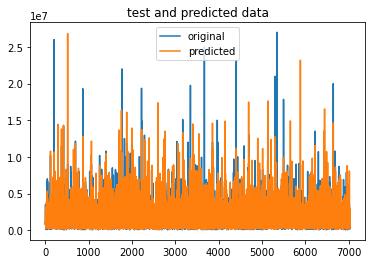

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, predict_LR, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()


In [ ]:
# Normalization:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
LRscaled = LinearRegression().fit(X_train, np.log(y_train+1))
predict_LRscaled = np.exp(LRscaled.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_LRscaled))*100:0.2f}%")


Точность модели по метрике MAPE: 26.58%


Нормализация не уменьшила ошибку

### result:
        data_ML: 28.00%
        data_noouts: 26.73%
        data_dum:
        data_noouts_dum:

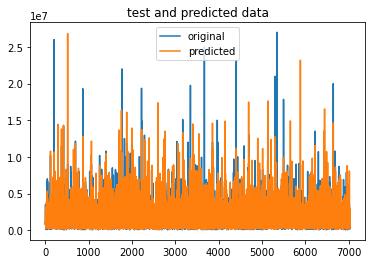

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, predict_LRscaled, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()


### 4.  Gradientboosting regressor

In [ ]:
GBR = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03,
                                max_depth=10, n_estimators=300, random_state=42)
GBR.fit(X_train, np.log(y_train+1))
predict_GBR = np.exp(GBR.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_GBR))*100:0.2f}%")


Точность модели по метрике MAPE: 13.52%


### result:
        data_ML: 13.94%
        data_noouts: 13.52%
        data_dum:
        data_noouts_dum:

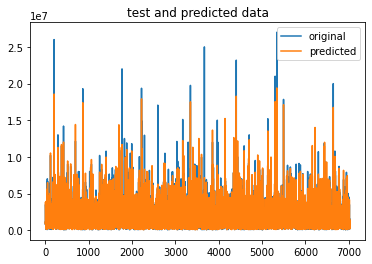

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, predict_GBR, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()


### 4a.  XGBRegressor

In [48]:
import xgboost as xgb
XGBR = xgb.XGBRegressor(random_state=42, verbosity=0) 
XGBR.fit(X_train, np.log(y_train+1))
predict_XGBR = np.exp(XGBR.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_XGBR))*100:0.2f}%")


Точность модели по метрике MAPE: 17.61%


### result:
        data_ML: 
        data_noouts: 14.42%
        data_dum:
        data_noouts_dum:

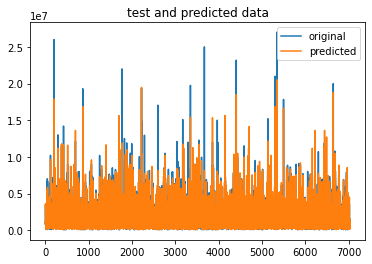

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, predict_XGBR, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()


### 5. LogisticRegression

целевая переменная не категориальная,  потому LogisticRegression не подходит 

### 6. Lazypredict

In [ ]:
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)


In [ ]:
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# print(models)

### result:
        

![Screen%20Shot%202021-10-22%20at%2000.11.15.png](attachment:Screen%20Shot%202021-10-22%20at%2000.11.15.png)

## Выбор модели (более общий вариант)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) :   MAPE = 26.58%


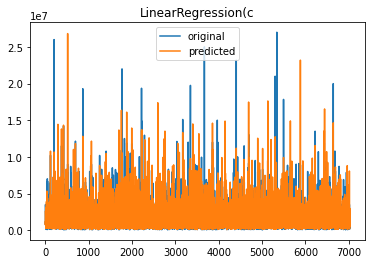






GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.03, loss='ls',
                          max_depth=10, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) :   MAPE = 13.52%


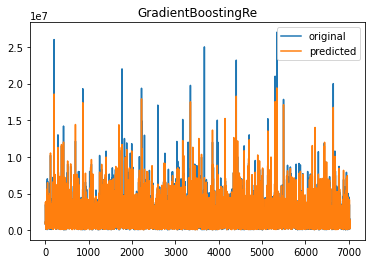






XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0) :   MAPE = 17.61%


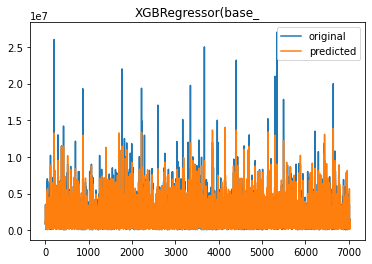

In [50]:
LR = LinearRegression()
GBR = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03,
                                max_depth=10, n_estimators=300, random_state=42)
XGBR = xgb.XGBRegressor(random_state=42, verbosity=0) 


y = df_train["price"]
X = df_train.drop("price", axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


models = [LR, GBR, XGBR]
for model in models:
    model.fit(X_train, np.log(y_train+1))
    y_pred = np.exp(model.predict(X_test))
    print("\n")                
    print(model,
    f":   MAPE = {(mape(y_test, y_pred))*100:0.2f}%")
    
    
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title(str(model)[:18])
    plt.legend()
    plt.show()
    print("\n\n")

## Стэкинг
За основу final_estimator возьмем алгоритм, предсказавший лучший результат - градиентный бустинг

In [ ]:
estimators = [('gbr',GradientBoostingRegressor(min_samples_split=2,
                                               learning_rate=0.03,
                                               max_depth=10,
                                               n_estimators=300,
                                               random_state=42)),
              ('cbr', CatBoostRegressor(iterations = 5000,
                                        random_state = 42,
                                        eval_metric='MAPE',
                                        silent=True))]


final_estimator = GradientBoostingRegressor(random_state=42, 
                                            max_depth=5, 
                                            min_samples_split=3, 
                                            n_estimators=1000)
stack_reg = StackingRegressor(
     estimators=estimators,
     final_estimator=final_estimator)
stack_reg.fit(X_train, np.log(y_train+1))

predict_stack_reg = np.exp(stack_reg.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_stack_reg))*100:0.2f}%")


Точность модели по метрике MAPE: 14.01%


### result:
    data_ML: 14.49%
    data_noouts: 14.01%
    data_dum:
    data_noouts_dum

## 2...

In [51]:
estimators = [('xgb', XGBRegressor(random_state=42, 
                                   verbosity=0)),
              ('cbr', CatBoostRegressor(iterations = 5000,
                       random_state = 42,
                       eval_metric='MAPE',
                        silent=True)),
]
final_estimator = GradientBoostingRegressor(random_state=42, 
                                            max_depth=5, 
                                            min_samples_split=3, 
                                            n_estimators=1000)
reg = StackingRegressor(
     estimators=estimators,
     final_estimator=final_estimator)
reg.fit(X_train, np.log(y_train+1))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(reg.predict(X_test))))*100:0.2f}%")


Точность модели по метрике MAPE: 13.93%


## SUBMISSION

In [54]:
sample_submission = pd.read_csv('/content/drive/My Drive/module_6/sample_submission.csv')


In [ ]:
X_train[0]


In [ ]:
df_test.values[0]


обучим модель на всей тестовой выборке

In [57]:
stack_reg.fit(X, np.log(y+1))
# GBR.fit(X, np.log(y+1))


StackingRegressor(cv=None,
                  estimators=[('gbr',
                               GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.03,
                                                         loss='ls',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                               

In [58]:
predict_stack_reg = np.exp(stack_reg.predict(df_test.values))

In [59]:
predict_stack_reg[0:10]

array([ 865947.12358358, 1318496.95919102, 1278703.09355882,
       1062169.87000539, 1073054.00319438,  909478.83600989,
        978403.53521243,  505309.79216212, 2257093.98376212,
       1146889.02052566])

In [63]:
predict_submission = np.round(predict_stack_reg, -3).astype(int)

In [64]:
predict_submission[0:10]

array([ 779400., 1186200., 1151100.,  955800.,  965700.,  818100.,
        880200.,  454500., 2031300., 1032300.])

In [65]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_v2.csv', index=False)
sample_submission.head(10)


,sell_id,price
0,1100575026,779400.0
1,1100549428,1186200.0
2,1100658222,1151100.0
3,1100937408,955800.0
4,1101037972,965700.0
5,1100912634,818100.0
6,1101228730,880200.0
7,1100165896,454500.0
8,1100768262,2031300.0
9,1101218501,1032300.0


In [67]:
from google.colab import files

In [68]:
files.download('submission_v2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>